<div style="text-align: center; font-size: 30pt; font-weight: bold; margin: 1em 0em 1em 0em">Taxi</div>

For better readability, this `Jupyter Notebook` calls upon a separate module, defined in `taxi.py`.

In [1]:
import gym

from tqdm import tqdm

from itertools import product

import numpy as np

In [2]:
np.set_printoptions(precision=2)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# LaTeX rendering in graphs
try:
    plt.rc('text', usetex=True)
except:
    pass

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [5]:
%reload_ext autoreload
%autoreload 2

In [6]:
import taxi

In [7]:
environment = gym.make('Taxi-v2')

# U-shaped curves

## Useful functions

In [8]:
alphas = [0.1, 0.5, .9]
temperatures = [.5, 1, 2]

In [9]:
def get_returns(agent, segments=100, runs=10):
    return np.array([agent.run(segments) for _ in range(runs)])

In [10]:
def try_parameters(agent_class, alphas, temperatures, name, filename):
    
    tries = np.empty((len(alphas), len(temperatures), 2))
    
    iterator = tqdm(
        product(enumerate(temperatures), enumerate(alphas)),
        ascii=True,
        ncols=100,
        total=9
    )
    
    for (i, temperature), (j, alpha) in iterator:
        agent = agent_class(environment, alpha=alpha, temperature=temperature)
        tries[i, j] = get_returns(agent)[:, -1, :].mean(axis=0)
    
    for mode in ['training', 'testing']:
        plt.figure(figsize=(7, 5))
        
        ts = tries[:, :, 0] if mode == 'training' else tries[:, :, 1]

        for t, temperature in zip(ts, temperatures):
            plt.plot(alphas, t, label=r'temperature $T = {}$'.format(temperature))

        plt.xlabel('Learning rate')
        plt.ylabel('Mean return')
        
        plt.title('{} ({})'.format(name, mode), fontsize=14)
        
        plt.legend(fontsize=11)
        plt.savefig('report/graphics/taxi/{}-mean-{}-return.pdf'.format(filename, mode), bbox_inches='tight')
        plt.show()

## Experiments

### Sarsa

In [38]:
agent = taxi.Sarsa(environment, gamma=1, alpha=.9, temperature=1, seed=None, verbose=True)
agent.initialise()

100%|#################################################################| 9/9 [04:16<00:00, 26.47s/it]


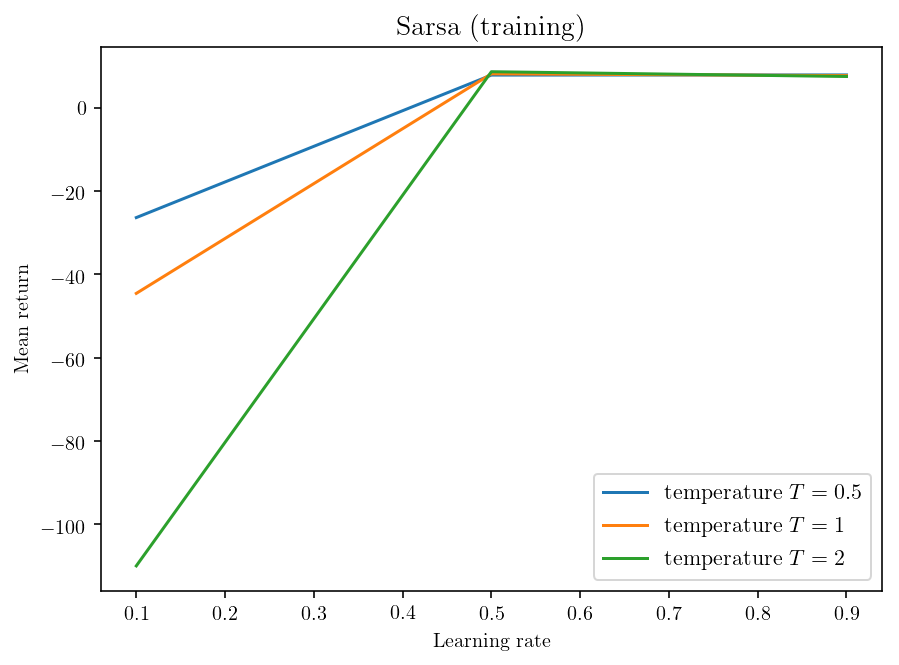

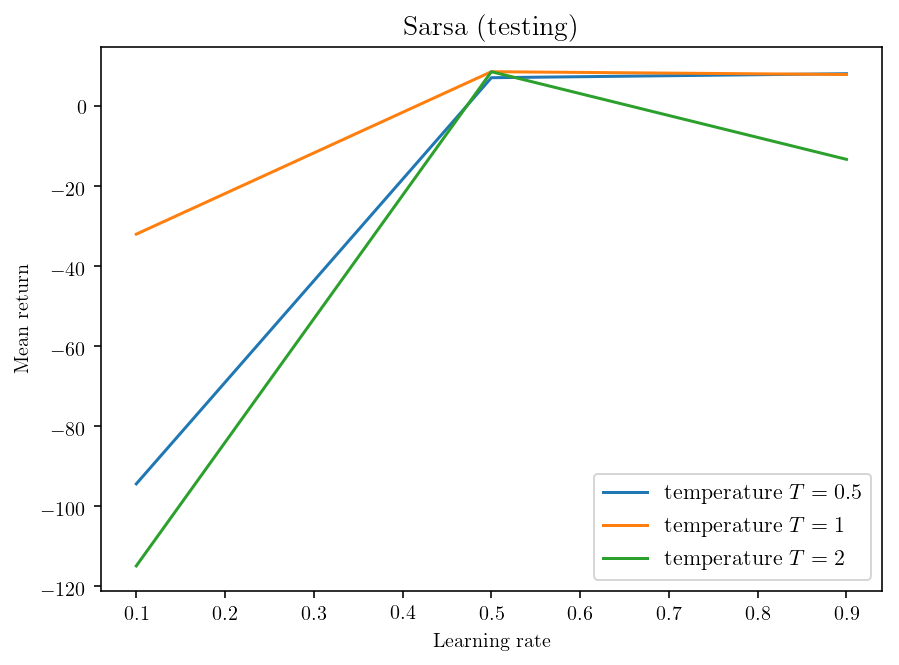

In [39]:
try_parameters(taxi.Sarsa, alphas, temperatures, 'Sarsa', 'sarsa')

### Expected Sarsa

In [40]:
agent = taxi.ExpectedSarsa(environment, gamma=1, alpha=.9, temperature=1, seed=0, verbose=True)
agent.initialise()

100%|#################################################################| 9/9 [04:51<00:00, 31.21s/it]


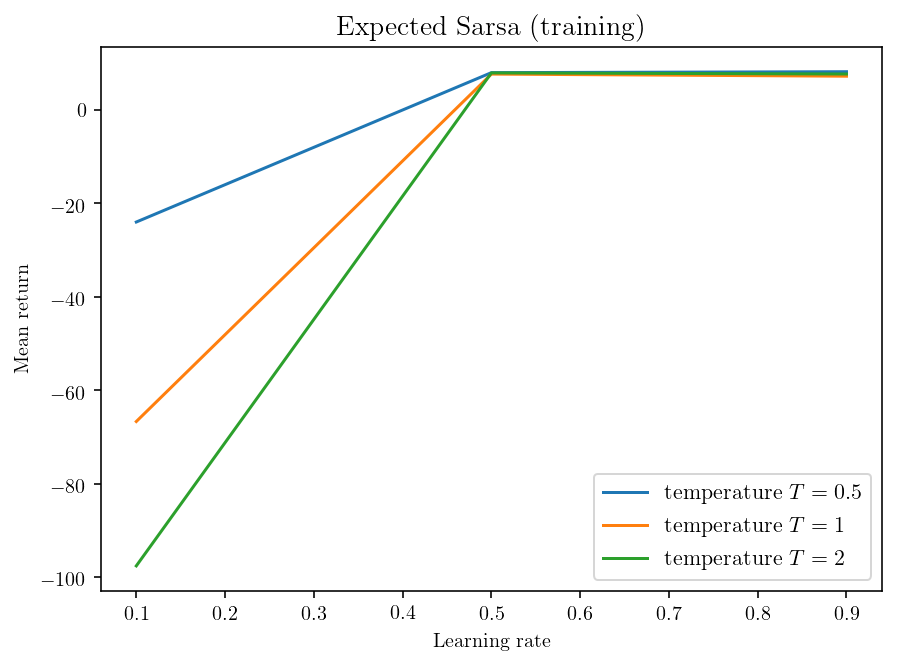

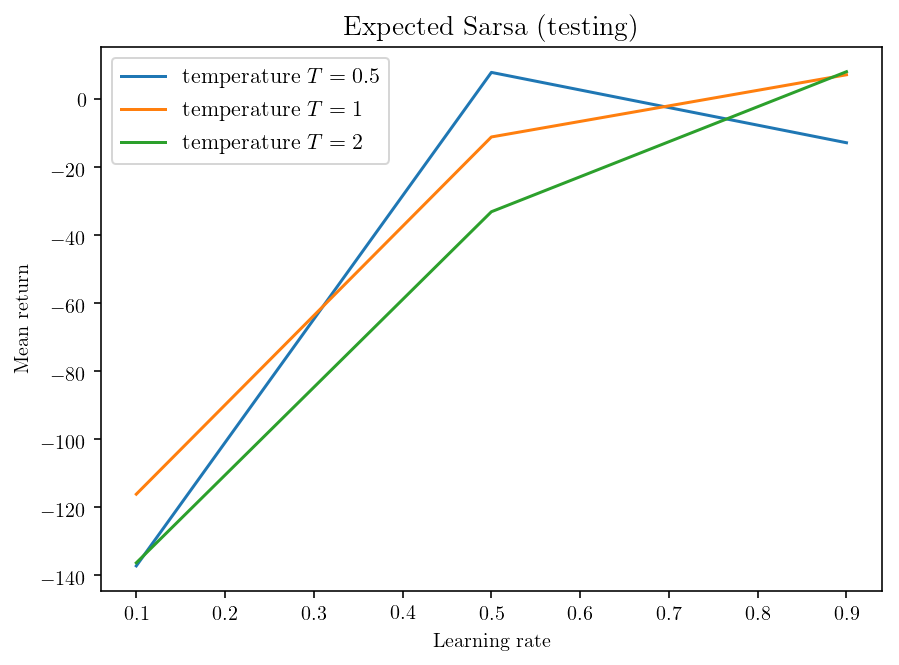

In [41]:
try_parameters(taxi.ExpectedSarsa, alphas, temperatures, 'Expected Sarsa', 'expsarsa')

### Q-Learning

In [43]:
agent = taxi.QLearning(environment, gamma=1, alpha=.9, temperature=1, seed=0, verbose=True)

100%|#################################################################| 9/9 [04:24<00:00, 28.14s/it]


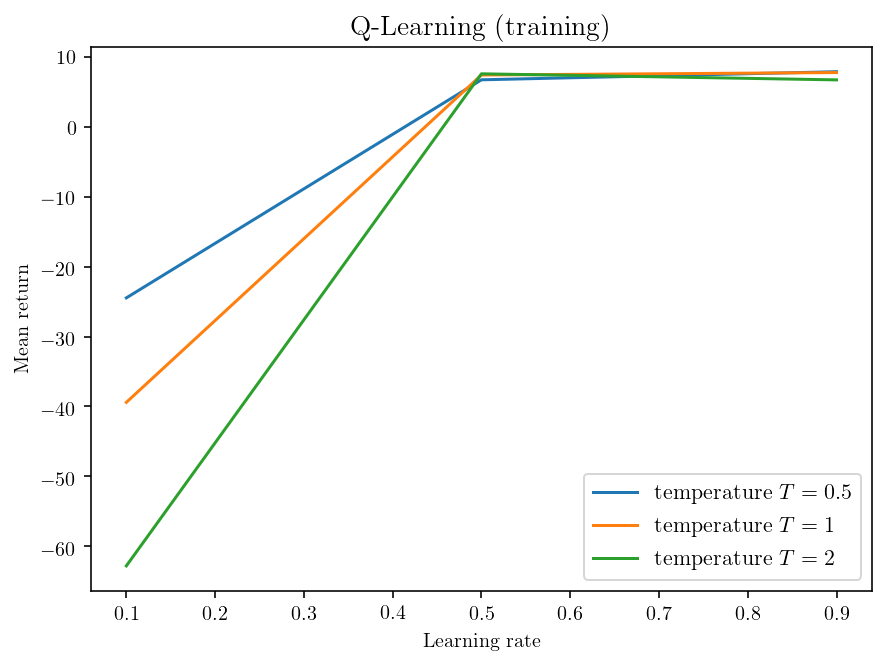

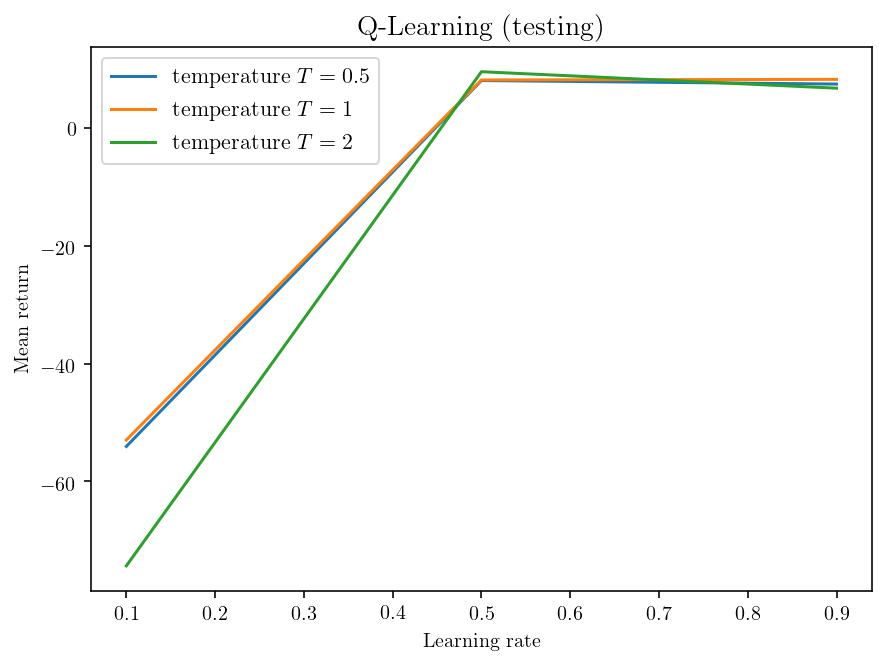

In [44]:
try_parameters(taxi.QLearning, alphas, temperatures, 'Q-Learning', 'qlearning')

# Learning curve

## Useful functions

In [47]:
def plot_learning_curves():
    
    agents = [
        taxi.Sarsa(environment, gamma=1, alpha=.9, temperature=1, seed=None, verbose=False),
        taxi.ExpectedSarsa(environment, gamma=1, alpha=.9, temperature=1, seed=None, verbose=False),
        taxi.QLearning(environment, gamma=1, alpha=.9, temperature=1, seed=None, verbose=False)
    ]
    
    names = ['Sarsa', 'Expected Sarsa', 'Q-Learning']
    filenames = ['sarsa', 'expsarsa', 'qlearning']
    
    for index, (agent, name, filename) in enumerate(zip(agents, names, filenames)):
        
        plt.figure(figsize=(8, 5))
        
        returns = get_returns(agent)
        
        color = 'C{}'.format(index)
        
        training_returns = returns[:, :, 0]
        tr_mean = training_returns.mean(axis=0)
        tr_std = training_returns.std(axis=0)
        tr_90 = np.percentile(training_returns, 90, axis=0)
        tr_10 = np.percentile(training_returns, 10, axis=0)

        # plt.plot(tr_90, label='9th decile', linestyle='--', color='green', linewidth=.8)
        # plt.plot(tr_10, label='1st decile', linestyle='--', color='red', linewidth=.8)
        plt.plot(tr_mean, label=name, color=color)

        plt.fill_between(
            np.arange(len(tr_mean)), 
            tr_mean + tr_std, 
            tr_mean - tr_std,
            color=color, 
            alpha=.4,
            label=r'Standard deviation'
        )
    
        plt.xlabel('Number of episode', size=13)
        plt.ylabel('Mean return', size=13)
        plt.legend(ncol=2, fontsize=11)
        plt.savefig('report/graphics/taxi/{}-learning-curve.pdf'.format(filename), bbox_inches='tight')
        plt.show()

## Experiment

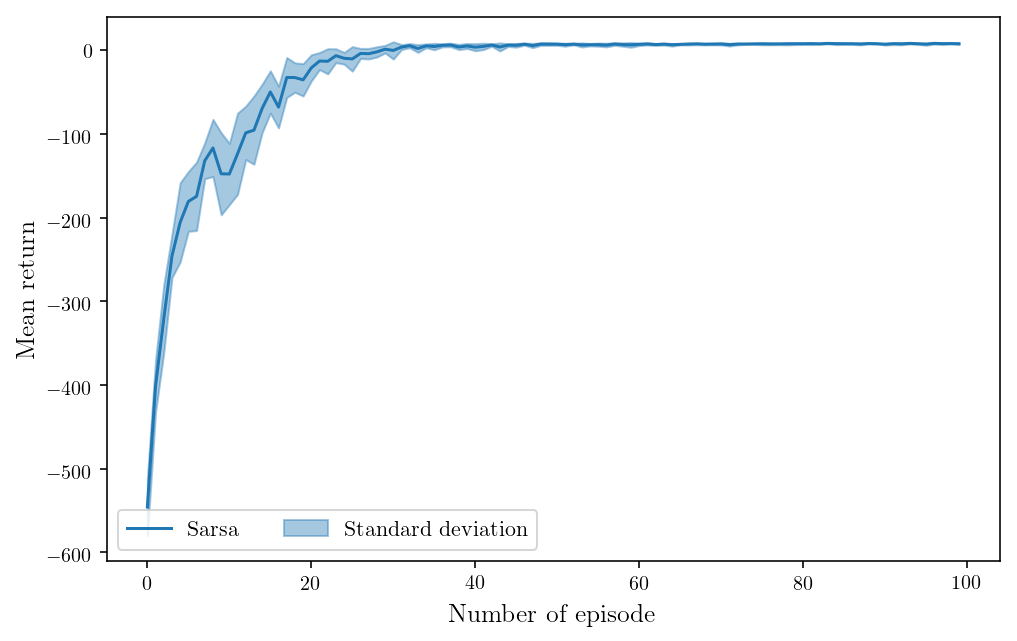

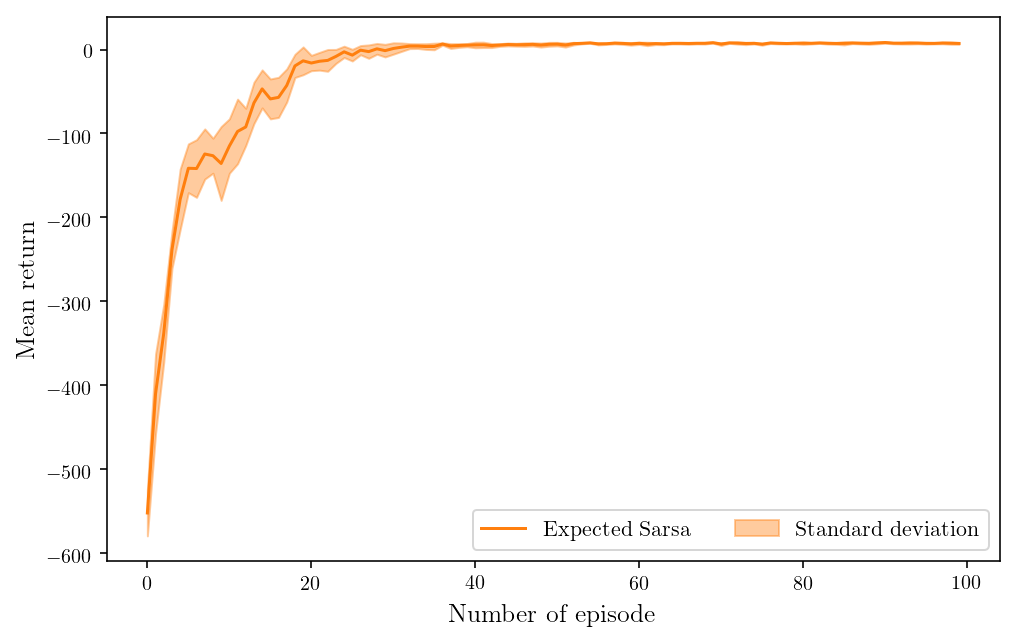

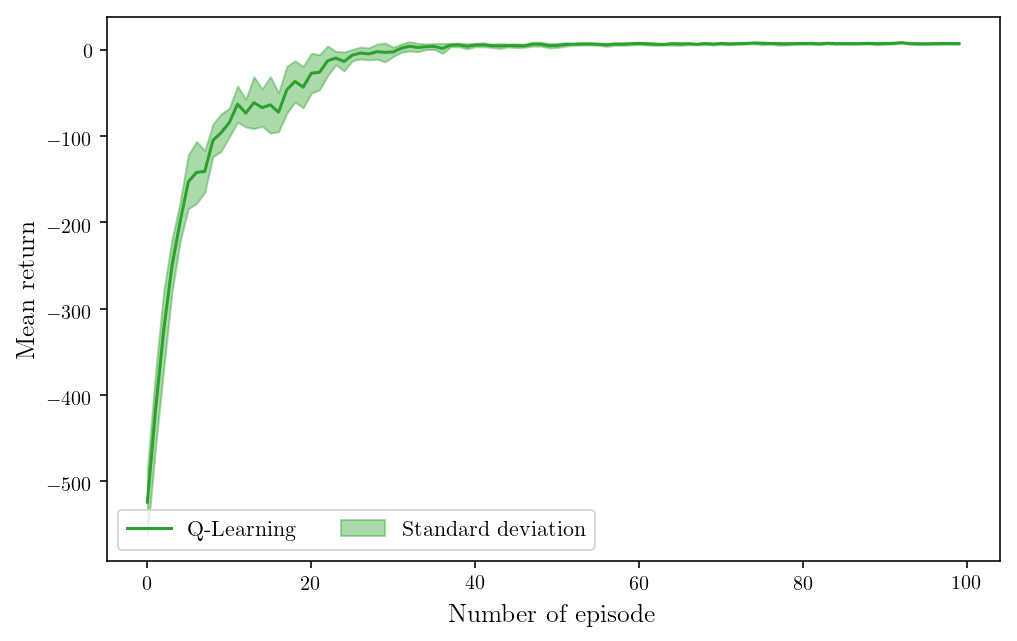

In [48]:
plot_learning_curves()

# Tests

100%|#############################################################| 200/200 [00:08<00:00, 23.03it/s]


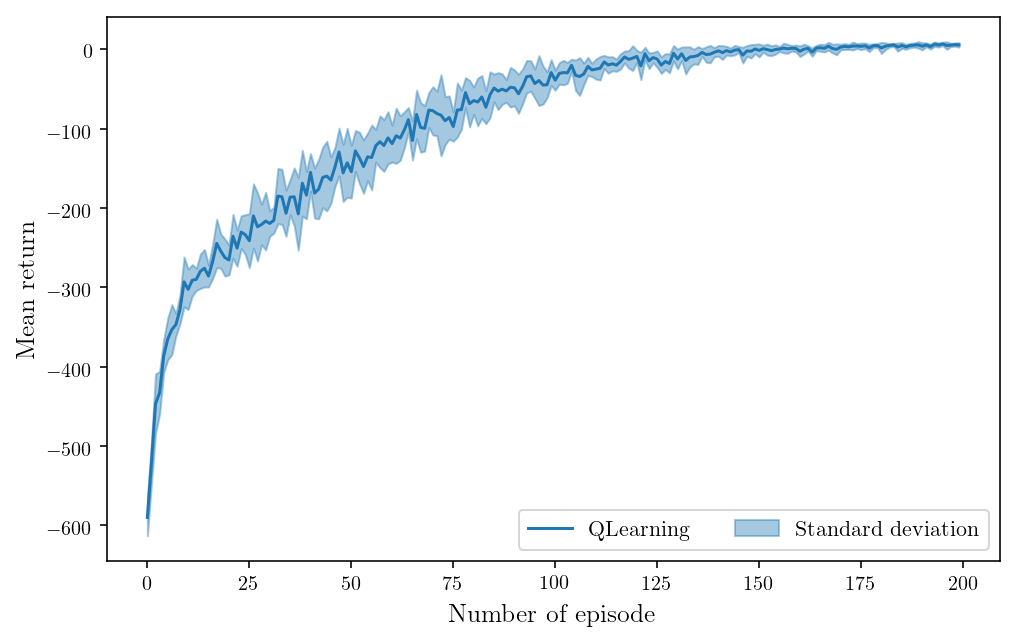

In [12]:
name = 'QLearning'
agent = taxi.QLearning(environment, gamma=1, alpha=.1, temperature=1, seed=None, verbose=True)

plt.figure(figsize=(8, 5))
        
returns = get_returns(agent, segments=200)

color = 'C0'

training_returns = returns[:, :, 0]
tr_mean = training_returns.mean(axis=0)
tr_std = training_returns.std(axis=0)
tr_90 = np.percentile(training_returns, 90, axis=0)
tr_10 = np.percentile(training_returns, 10, axis=0)

# plt.plot(tr_90, label='9th decile', linestyle='--', color='green', linewidth=.8)
# plt.plot(tr_10, label='1st decile', linestyle='--', color='red', linewidth=.8)
plt.plot(tr_mean, label=name, color=color)

plt.fill_between(
    np.arange(len(tr_mean)), 
    tr_mean + tr_std, 
    tr_mean - tr_std,
    color=color, 
    alpha=.4,
    label=r'Standard deviation'
)

plt.xlabel('Number of episode', size=13)
plt.ylabel('Mean return', size=13)
plt.legend(ncol=2, fontsize=11)
plt.savefig('report/graphics/taxi/qlearning-a01-t1-200ep-learning-curve.pdf', bbox_inches='tight')
plt.show()